# Imports

In [1]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torchmetrics

import torch
import torchvision
import torch.nn as nn

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from dnn_app_utils_v3 import *
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [3]:
import numpy as np
import h5py
    
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, np.transpose(train_set_y_orig), test_set_x_orig, np.transpose(test_set_y_orig), classes


In [4]:
train_x, train_y, test_x, test_y, classes = load_dataset()

In [5]:
print(f'Train x shape is - {train_x.shape}, Train y shape is - {train_y.shape}')
print(f'Test x shape is - {test_x.shape}, Test y shape is - {test_y.shape}')

Train x shape is - (209, 64, 64, 3), Train y shape is - (209, 1)
Test x shape is - (50, 64, 64, 3), Test y shape is - (50, 1)


# EDA

y = 1. It's a cat picture.


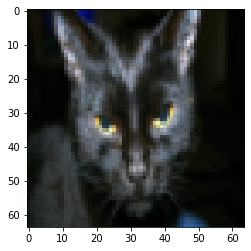

In [6]:
# Example of a picture
index = 25
plt.imshow(train_x[index])
print ("y = " + str(train_y[index,0]) + ". It's a " + classes[train_y[index,0]].decode("utf-8") +  " picture.")

# Dataset loading

In [7]:
class CatorNotCatDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
    def __getitem__(self,index):
        image = torch.from_numpy(self.x[index].reshape(-1,)/255).float()
        label = torch.from_numpy(self.y[index].reshape(1,)).float()
        return image,label
        
    def __len__(self):
        return len(self.x)

In [8]:
train_dataset = CatorNotCatDataset(train_x,train_y)
test_dataset =  CatorNotCatDataset(test_x,test_y)

In [9]:
class DNN(nn.Module):
    def __init__(self,n_input_features):
        super().__init__()
        self.n_input_features = n_input_features
        self.model = nn.Sequential(OrderedDict([
          ('Linear1', nn.Linear(n_input_features,1)),
          ('Sigmoid1', nn.ReLU())
        ]))
        
    def forward(self,x):
        model_output = self.model(x.reshape(-1,self.n_input_features))
        return model_output

In [10]:
model = DNN(train_dataset[0][0].shape[0])

In [11]:
sample = train_dataset[0][0]
model.forward(sample)

tensor([[0.]], grad_fn=<ReluBackward0>)

# Model Parameters and data loader

In [12]:
learning_rate = 0.001
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 50

In [13]:
batch_size = 16

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True,num_workers=4)

Epoch [50/50]: 100%|██████████| 14/14 [00:00<00:00, 88.64it/s, accuracy=100, loss=0.117]


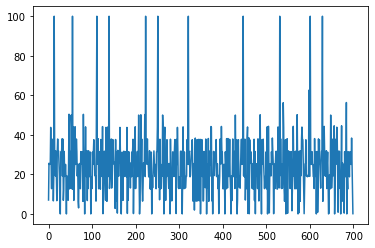

In [14]:
metric = torchmetrics.Accuracy()
training_loss = []

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx,(inputs,labels) in loop: 
        y_predicted = model(inputs)
        y_predicted = y_predicted.reshape(-1,)
        labels = labels.reshape(-1,)
        loss = criterion(y_predicted,labels)
        
        # Backward pass
        loss.backward()
        
        # Accuracy
        acc = metric(y_predicted,labels.int())
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss = loss.item(), accuracy = acc.item()*100)
        training_loss.append(loss.item())
        
plt.plot(training_loss)
plt.show()